# Read Data

In [213]:
import numpy as np
import scanpy as sc

adata = sc.read_h5ad(
    "/home/jhaberbe/Projects/Personal/TokenGT/data/output-dgi-10-10-20MAY2025.h5ad"
)
adata = adata[adata.layers["transcript"].sum(axis=1) > 20].copy()
adata.obs["log_plin2_area"] = np.log1p(adata.obs["plin2_area"])
adata.obs["log_oil_red_o_area"] = np.log1p(adata.obs["oil_red_o_area"])
adata.obs["log_lipid_droplet_area"] = np.log1p(adata.obs["lipid_droplet_area"])

adata.X = adata.layers["transcript"].copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
adata.X seems to be already log-transformed.


In [214]:
from scipy.spatial import cKDTree
adata.obs["z_centroid"] = adata.obs["folder"].replace({
    k: i * 10_000
    for i, k in enumerate(adata.obs["folder"].unique())
})

ckd_tree = cKDTree(adata.obs[["x_centroid", "y_centroid", "z_centroid"]])

_, neighbor_indicies = ckd_tree.query(adata.obs[["x_centroid", "y_centroid", "z_centroid"]], k = 31)
neighbor_indicies = neighbor_indicies.tolist()

/tmp/ipykernel_3674434/2419312085.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  adata.obs["z_centroid"] = adata.obs["folder"].replace({
/tmp/ipykernel_3674434/2419312085.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs["z_centroid"] = adata.obs["folder"].replace({


# Data Set 

In [222]:
import torch

class SpatialSingleCellDataSet:
    
    def __init__(
        self, 
        counts,
        log_normalized,
        plin2_area,
        oil_red_o_area,
        lipid_droplet_area,
        near_amyloid,
        neighbor_indices,
        specimen_ids
    ):
        # Gene Expression Information
        self.counts = self._to_tensor(counts, torch.float)
        self.log_normalized = self._to_tensor(log_normalized, torch.float)

        self.size_factors = (self.counts.sum(axis=1) / self.counts.sum(axis=1).mean()).log()

        # Pathology Information
        self.plin2_area = self._to_tensor(plin2_area, torch.float)
        self.oil_red_o_area = self._to_tensor(oil_red_o_area, torch.float)
        self.lipid_droplet_area = self._to_tensor(lipid_droplet_area, torch.float)
        self.near_amyloid = self._to_tensor(near_amyloid, torch.float)

        # Neighborhood Information
        self.specimen_ids = self._to_tensor(specimen_ids, torch.long)
        self.neighbor_indices = self._to_tensor(neighbor_indices, torch.long)

    @staticmethod
    def _to_tensor(x, dtype=torch.float):
        if isinstance(x, torch.Tensor):
            return x.detach().clone().to(dtype)
        else:
            return torch.tensor(x, dtype=dtype)

    def __len__(self):
        return self.counts.size(0)

    def __getitem__(self, idx):
        return {
            # Expression Information
            "counts": self.counts[idx],
            "log_normalized": self.log_normalized[idx],
            "size_factors": self.size_factors[idx],

            # Pathology Information
            "plin2_area": self.plin2_area[idx],
            "oil_red_o_area": self.oil_red_o_area[idx],
            "lipid_droplet_area": self.lipid_droplet_area[idx],
            "near_amyloid": self.near_amyloid[idx],

            # Neighborhood Information
            "neighbor_indices": self.neighbor_indices[idx],

            # Cell Metadata
            "specimen_ids": self.specimen_ids[idx],
        }

counts = torch.tensor(adata.layers["transcript"])
log_normalized = torch.tensor(adata.X)

plin2_area = torch.tensor(adata.obs["plin2_area"].values).log1p()
oil_red_o_area = torch.tensor(adata.obs["oil_red_o_area"].values).log1p()
lipid_droplet_area = torch.tensor(adata.obs["lipid_droplet_area"].values).log1p()
near_amyloid = torch.tensor(adata.obs["near_amyloid"].values).float()

neighbor_indices = torch.tensor(neighbor_indicies)
specimen_ids = torch.tensor(adata.obs["folder"].cat.codes.values)

dataset = SpatialSingleCellDataSet(
    counts,
    log_normalized,
    plin2_area,
    oil_red_o_area,
    lipid_droplet_area,
    near_amyloid,
    neighbor_indices,
    specimen_ids
)

input_data = dataset[0]

dataset[input_data["neighbor_indices"]]

{'counts': tensor([[0., 0., 1.,  ..., 1., 0., 0.],
         [0., 1., 1.,  ..., 4., 0., 0.],
         [0., 0., 0.,  ..., 2., 0., 0.],
         ...,
         [1., 0., 2.,  ..., 1., 0., 0.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'log_normalized': tensor([[0.0000, 0.0000, 1.0282,  ..., 1.0282, 0.0000, 0.0000],
         [0.0000, 0.5346, 0.5346,  ..., 1.3422, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 1.3048, 0.0000, 0.0000],
         ...,
         [0.2622, 0.0000, 0.4698,  ..., 0.2622, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.6243,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'size_factors': tensor([-0.7850,  0.1475, -0.4948,  0.5161, -0.2460, -0.5742, -0.0276, -0.7748,
          0.2358,  0.4046, -0.3593,  0.4678,  0.4412,  0.9418,  0.9048,  0.6938,
         -0.0767,  0.9490, -0.2342, -1.6564,  0.5217, -0.0518,  0.2358,  0.7123,
         -0.0667,  0.5807,  0.2577,  0.4077, 

In [223]:
import torch
from torch import nn
from torch.autograd import Function
import torch.nn.functional as F

# Gradient Reversal Layer implementation
class GradReverse(Function):
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.view_as(x)  # Identity forward pass

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.lambda_, None

def grad_reverse(x, lambda_=1.0):
    return GradReverse.apply(x, lambda_)

# Variational Encoder (unchanged)
class VariationalEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.mu = nn.Linear(hidden_dim, embedding_dim)
        self.log_var = nn.Linear(hidden_dim, embedding_dim)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        h = self.shared(x)
        log_mu = self.mu(h)
        log_var = self.log_var(h)
        return log_mu, log_var

In [224]:

# Spatial Decoder (same as before, you can copy your existing decoder here)
class Decoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_genes, n_batches):
        super().__init__()
        self.batch_emb = nn.Embedding(n_batches, embedding_dim)
        self.shared = nn.Sequential(
            nn.Linear(embedding_dim * 2, hidden_dim),
            nn.ReLU()
        )
        self.nb_mu = nn.Linear(hidden_dim, n_genes)
        self.log_theta = nn.Parameter(torch.zeros(1))
        self.hurdle_logits = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.hurdle_mu = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.hurdle_log_var = nn.ModuleDict({
            "plin2": nn.Linear(hidden_dim, 1),
            "oil_red_o": nn.Linear(hidden_dim, 1),
            "lipid_droplet": nn.Linear(hidden_dim, 1)
        })
        self.near_amyloid_logit = nn.Linear(hidden_dim, 1)
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z, specimen_ids):
        batch_embedding = self.batch_emb(specimen_ids)
        h = self.shared(torch.cat([z, batch_embedding], dim=-1))
        log_mu_counts = self.nb_mu(h)
        log_theta = self.log_theta.expand_as(log_mu_counts)
        hurdle_out = {}
        for k in self.hurdle_logits.keys():
            hurdle_out[k] = {
                "logit_p": self.hurdle_logits[k](h),
                "mu": self.hurdle_mu[k](h),
                "log_var": self.hurdle_log_var[k](h)
            }
        near_amyloid_logit = self.near_amyloid_logit(h)
        return {
            "log_mu_counts": log_mu_counts,
            "log_theta": log_theta,
            "hurdle": hurdle_out,
            "near_amyloid_logit": near_amyloid_logit
        }

In [225]:
# Discriminator to predict specimen_ids from latent z
class Discriminator(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, n_batches):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_batches)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, z):
        return self.net(z)


In [226]:
# Full VAE with adversarial batch correction
class VAEWithAdversarial(nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim, n_genes, n_batches):
        super().__init__()
        self.encoder = VariationalEncoder(input_dim, hidden_dim, embedding_dim)
        self.decoder = Decoder(embedding_dim, hidden_dim, n_genes, n_batches)
        self.discriminator = Discriminator(embedding_dim, hidden_dim // 2, n_batches)

    def reparameterize(self, log_mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return log_mu + eps * std

    def forward(self, input_data):
        x = input_data["log_normalized"]
        specimen_ids = input_data["specimen_ids"]

        log_mu, log_var = self.encoder(x)
        z = self.reparameterize(log_mu, log_var)

        outputs = self.decoder(z, specimen_ids)
        outputs["size_factors"] = input_data["size_factors"]
        return outputs, log_mu, log_var, z

    def discriminate(self, z, lambda_grl=1.0):
        # Apply gradient reversal on z before discriminator
        z_rev = grad_reverse(z, lambda_grl)
        logits = self.discriminator(z_rev)
        return logits


In [235]:
import torch
import torch.nn.functional as F

# 1) Negative Binomial loss for counts

def negative_binomial_loss(x, log_mu, log_theta, size_factors):
    """
    x: observed counts (integer tensor)
    log_mu: decoded log mean (float tensor)
    log_theta: scalar or tensor, shared dispersion (log scale)
    size_factors: tensor, log scale size factors (same shape as batch size)
    """
    # Adjust log_mu by adding size factors (log scale)
    # size_factors shape: (batch_size,)
    # log_mu shape: (batch_size, n_genes)
    log_mu_adj = log_mu + size_factors.unsqueeze(-1)  # broadcast size_factors

    theta = torch.exp(log_theta)  # dispersion

    # logits for NB parameterization: logits = log_mu - log(mu + theta)
    logits = log_mu_adj - torch.log(torch.exp(log_mu_adj) + theta)

    nb_dist = torch.distributions.NegativeBinomial(total_count=theta, logits=logits)
    # Negative log likelihood (sum over genes and batch)
    neg_log_likelihood = -nb_dist.log_prob(x).sum()

    return neg_log_likelihood


# 2) Hurdle normal loss for each pathology feature

def hurdle_normal_loss(x, logit_p, mu, log_var):
    p = torch.sigmoid(logit_p)
    is_zero = (x == 0).float()

    bern_loss = -(is_zero * torch.log(1 - p + 1e-8) + (1 - is_zero) * torch.log(p + 1e-8))

    std = torch.exp(0.5 * log_var)
    const = torch.log(torch.tensor(2 * torch.pi, device=x.device, dtype=x.dtype))
    gaussian_nll = 0.5 * ( ((x - mu) / std) ** 2 + 2 * torch.log(std) + const )
    gaussian_nll = gaussian_nll * (1 - is_zero)

    total_loss = (bern_loss + gaussian_nll).sum()
    return total_loss


# 3) Logistic loss for near_amyloid (binary classification)

def near_amyloid_loss(logits, labels):
    """
    logits: raw logits output from decoder (before sigmoid)
    labels: binary labels (0/1 float tensor)
    """
    loss = F.binary_cross_entropy_with_logits(logits.squeeze(-1), labels, reduction='sum')
    return loss


# 4) KL divergence between latent posterior and prior

def kl_divergence(log_mu, log_var):
    """
    Standard VAE KL divergence
    """
    kl = -0.5 * torch.sum(1 + log_var - log_mu.pow(2) - log_var.exp())
    return kl

def discriminator_loss(discriminator_logits, specimen_ids):
    """
    Cross-entropy loss for discriminator predicting specimen_ids.
    """
    return F.cross_entropy(discriminator_logits, specimen_ids)

def compute_total_loss(
    outputs,
    input_data,
    log_mu,
    log_var,
    discriminator_logits=None,
    weight_kl=1.0,
    weight_nb=1.0,
    weight_hurdle=1.0,
    weight_amyloid=1.0,
    weight_adv=0.0,
):
    """
    Computes total loss for VAE model, optionally including adversarial loss.

    If `discriminator_logits` is provided, compute adversarial loss and include weighted in total loss.
    """

    # Negative Binomial loss (counts)
    nb_loss = negative_binomial_loss(
        x=input_data["counts"],
        log_mu=outputs["log_mu_counts"],
        log_theta=outputs["log_theta"],
        size_factors=input_data["size_factors"]
    )

    # Hurdle normal losses (sum over 3 features)
    hurdle_loss = 0.0
    for key in ["plin2", "oil_red_o", "lipid_droplet"]:
        h = outputs["hurdle"][key]
        x = input_data[f"{key}_area"]
        hurdle_loss += hurdle_normal_loss(x, h["logit_p"], h["mu"], h["log_var"])

    # Near amyloid logistic loss
    amyloid_loss = near_amyloid_loss(outputs["near_amyloid_logit"], input_data["near_amyloid"])

    # KL divergence
    kl_loss = kl_divergence(log_mu, log_var)

    # Adversarial loss (optional)
    if discriminator_logits is not None:
        adv_loss = discriminator_loss(discriminator_logits, input_data["specimen_ids"])
    else:
        adv_loss = torch.tensor(0.0, device=log_mu.device)

    # Total loss
    total_loss = (
        weight_nb * nb_loss
        + weight_hurdle * hurdle_loss
        + weight_amyloid * amyloid_loss
        + weight_kl * kl_loss
        + weight_adv * adv_loss
    )

    return total_loss, {
        "total_loss": total_loss.item(),
        "nb_loss": nb_loss.item(),
        "hurdle_loss": hurdle_loss.item(),
        "amyloid_loss": amyloid_loss.item(),
        "kl_loss": kl_loss.item(),
        "adv_loss": adv_loss.item() if isinstance(adv_loss, torch.Tensor) else adv_loss
    }


In [237]:
import torch
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

batch_size = 2048
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: x)

vae = VAE(
    input_dim=366,
    hidden_dim=64,
    embedding_dim=8,
    n_genes=366,
    n_batches=12
).to(device)
vae.train()

discriminator = Discriminator(embedding_dim=8, hidden_dim=32, n_batches=12).to(device)
discriminator.train()

optimizer_vae = Adam(vae.parameters(), lr=1e-3)
optimizer_disc = Adam(discriminator.parameters(), lr=1e-3)

num_epochs = 10
adv_weight = 1.0
lambda_grl = 1.0

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch_idx, batch_samples in enumerate(data_loader):
        # Convert list of dicts to dict of batched tensors and send to device
        batch_data = {key: torch.stack([sample[key] for sample in batch_samples]).to(device) for key in batch_samples[0].keys()}

        # --- Step 1: Train discriminator ---
        for i in range(20):
            optimizer_disc.zero_grad()
            with torch.no_grad():
                log_mu, log_var = vae.encoder(batch_data["log_normalized"])
                z = vae.reparameterize(log_mu, log_var)

            disc_logits = discriminator(z.detach())
            disc_loss = torch.nn.functional.cross_entropy(disc_logits, batch_data["specimen_ids"])
            disc_loss.backward()
            optimizer_disc.step()

        # --- Step 2: Train VAE ---
        optimizer_vae.zero_grad()

        log_mu, log_var = vae.encoder(batch_data["log_normalized"])
        z = vae.reparameterize(log_mu, log_var)

        outputs = vae.decoder(z, batch_data["specimen_ids"])
        outputs["size_factors"] = batch_data["size_factors"]

        z_rev = grad_reverse(z, lambda_grl)
        adv_logits = discriminator(z_rev)

        loss, loss_items = compute_total_loss(
            outputs=outputs,
            input_data=batch_data,
            log_mu=log_mu,
            log_var=log_var,
            discriminator_logits=adv_logits,
            weight_adv=adv_weight
        )

        loss.backward()
        optimizer_vae.step()

        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}], Loss: {loss.item():.4f}, Disc Loss: {disc_loss.item():.4f}")

    epoch_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Average Loss: {epoch_loss:.4f}")

Using device: cuda
Epoch [1/10], Batch [0], Loss: 84713176.0000, Disc Loss: 2.5941
Epoch [1/10], Batch [10], Loss: 40192312.0000, Disc Loss: 2.4178
Epoch [1/10], Batch [20], Loss: 28667454.0000, Disc Loss: 2.3084
Epoch [1/10], Batch [30], Loss: 29433992.0000, Disc Loss: 2.2302
Epoch [1/10], Batch [40], Loss: 27540956.0000, Disc Loss: 2.2488
Epoch [1/10], Batch [50], Loss: 26322228.0000, Disc Loss: 2.2384
Epoch [1/10], Batch [60], Loss: 24626342.0000, Disc Loss: 2.2220
Epoch [1/10], Batch [70], Loss: 23780822.0000, Disc Loss: 2.2114
Epoch [1/10], Batch [80], Loss: 23753004.0000, Disc Loss: 2.2380
Epoch [1/10], Batch [90], Loss: 23016606.0000, Disc Loss: 2.2180
Epoch [1/10], Batch [100], Loss: 23164608.0000, Disc Loss: 2.2092
Epoch [1/10], Batch [110], Loss: 23189288.0000, Disc Loss: 2.2391
Epoch [1/10], Batch [120], Loss: 23020316.0000, Disc Loss: 2.2167
Epoch [1/10], Batch [130], Loss: 22948774.0000, Disc Loss: 2.2338
Epoch [1/10], Batch [140], Loss: 22731804.0000, Disc Loss: 2.2018
Ep

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x75857b01af90>>
Traceback (most recent call last):
  File "/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Epoch [2/10], Batch [100], Loss: 22720974.0000, Disc Loss: 2.1526
Epoch [2/10], Batch [110], Loss: 22161562.0000, Disc Loss: 2.2009
Epoch [2/10], Batch [120], Loss: 22558058.0000, Disc Loss: 2.1915
Epoch [2/10], Batch [130], Loss: 22390692.0000, Disc Loss: 2.1825
Epoch [2/10], Batch [140], Loss: 22045304.0000, Disc Loss: 2.1642
Epoch [2/10], Batch [150], Loss: 22352284.0000, Disc Loss: 2.1780
Epoch [2/10], Batch [160], Loss: 22425240.0000, Disc Loss: 2.1745
Epoch [2/10], Batch [170], Loss: 22532408.0000, Disc Loss: 2.1652
Epoch [2/10], Batch [180], Loss: 22673074.0000, Disc Loss: 2.1872
Epoch [2/10], Batch [190], Loss: 22128932.0000, Disc Loss: 2.1621
Epoch [2/10], Batch [200], Loss: 22197638.0000, Disc Loss: 2.1812
Epoch [2/10], Batch [210], Loss: 22222998.0000, Disc Loss: 2.1538
Epoch [2/10], Batch [220], Loss: 22051152.0000, Disc Loss: 2.1748
Epoch [2/10], Batch [230], Loss: 22370644.0000, Disc Loss: 2.1642
Epoch [2/10], Batch [240], Loss: 22430982.0000, Disc Loss: 2.1362
Epoch [2/1

KeyboardInterrupt: 

In [238]:
import torch
from torch.utils.data import DataLoader

def extract_embeddings(model, dataset, batch_size=256, use_mean=True, device=None):
    """
    Extract latent embeddings for all samples in `dataset`.

    Args:
        model: trained VAE model with encoder
        dataset: dataset object (e.g. SpatialSingleCellDataSet)
        batch_size: batch size for DataLoader
        use_mean: if True, use encoder's mean (log_mu) as embedding,
                  else sample from latent distribution
        device: torch device (e.g. 'cuda' or 'cpu'), default auto-detect

    Returns:
        embeddings: Tensor of shape (n_samples, embedding_dim)
    """

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    model.to(device)

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda x: x)

    all_embeddings = []

    with torch.no_grad():
        for batch_samples in loader:
            batch_data = {key: torch.stack([sample[key] for sample in batch_samples]).to(device) for key in batch_samples[0].keys()}

            log_mu, log_var = model.encoder(batch_data["log_normalized"])

            if use_mean:
                embeddings = log_mu
            else:
                std = torch.exp(0.5 * log_var)
                eps = torch.randn_like(std)
                embeddings = log_mu + eps * std

            all_embeddings.append(embeddings.cpu())

    return torch.cat(all_embeddings, dim=0)

token_embeddings = extract_embeddings(vae, dataset)

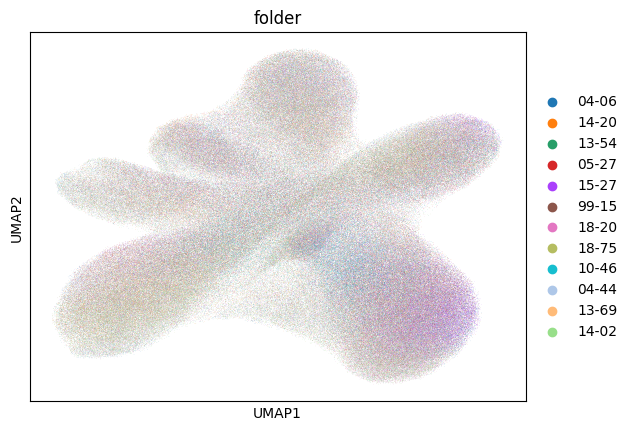

In [239]:
adata.obsm["X_token"] = token_embeddings.detach().cpu().numpy()
sc.pp.neighbors(adata, use_rep="X_token")
sc.tl.umap(adata)
sc.pl.umap(adata, color="folder")

# Embeddings

In [241]:
import torch
from torch.utils.data import Dataset

class SpatialEmbeddingDataset(Dataset):
    def __init__(self, embeddings, neighbor_indices):
        """
        Args:
            embeddings: Tensor of shape (n_cells, embedding_dim)
            neighbor_indices: LongTensor of shape (n_cells, n_neighbors)
        """
        self.embeddings = embeddings
        self.neighbor_indices = neighbor_indices

    def __len__(self):
        return self.embeddings.size(0)

    def __getitem__(self, idx):
        """
        Returns:
            {
                "center": embedding of center cell (embedding_dim,),
                "neighbors": embeddings of neighbors (n_neighbors, embedding_dim),
                "center_idx": index of the center cell
            }
        """
        center_embedding = self.embeddings[idx]
        neighbor_idxs = self.neighbor_indices[idx]
        neighbor_embeddings = self.embeddings[neighbor_idxs]

        return {
            "center": center_embedding,
            "neighbors": neighbor_embeddings,
            "center_idx": idx
        }

spatial_embedding_dataset = SpatialEmbeddingDataset(
    embeddings=token_embeddings,
    neighbor_indices=neighbor_indices[:, 1:]
)

In [242]:
from nflows.flows import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform

def build_simple_flow(embedding_dim, n_transforms=4, hidden_dim=64):
    base_dist = StandardNormal([embedding_dim])
    transforms = []
    for _ in range(n_transforms):
        transforms.append(
            MaskedAffineAutoregressiveTransform(
                features=embedding_dim,
                hidden_features=hidden_dim
            )
        )
    # Combine into a proper composite transform
    transform = CompositeTransform(transforms)
    return Flow(transform, base_dist)


In [ ]:
class SpatialTransformerFlow(nn.Module):
    def __init__(self, embedding_dim, n_heads=4, n_layers=6, n_neighbors=30):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.n_neighbors = n_neighbors

        # Learnable CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedding_dim))

        # Positional encoding (simple learnable)
        self.positional_enc = nn.Parameter(torch.randn(1, n_neighbors + 2, embedding_dim))

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embedding_dim, nhead=n_heads, dim_feedforward=embedding_dim * 4, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Normalizing Flow for predicting next-token embedding
        self.flow = build_simple_flow(embedding_dim)

    def forward(self, center, neighbors):
        """
        center: (B, embedding_dim)
        neighbors: (B, n_neighbors, embedding_dim)
        """
        B = center.size(0)
        device = center.device

        # Start with [CLS] + center
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, D)
        current_seq = torch.cat([cls_tokens, center.unsqueeze(1)], dim=1)

        all_log_probs = []

        for step in range(neighbors.size(1)):
            seq = current_seq + self.positional_enc[:, :current_seq.size(1), :]

            h = self.transformer(seq)  # (B, seq_len, D)
            context = h[:, -1, :]  # last token representation

            # Predict probability of the next token using the flow
            next_token = neighbors[:, step, :]
            log_prob = self.flow.log_prob(next_token)  # unconditional for now
            all_log_probs.append(log_prob)

            # Append the ground truth neighbor to the sequence for next step
            current_seq = torch.cat([current_seq, next_token.unsqueeze(1)], dim=1)

        all_log_probs = torch.stack(all_log_probs, dim=1)  # (B, n_neighbors)
        return all_log_probs

def perplexity_loss(log_probs):
    """
    log_probs: (B, n_neighbors), log p(next_token)
    Returns: scalar loss (average perplexity)
    """
    nll = -log_probs  # negative log-likelihood per step
    entropy = nll.mean()  # average entropy across batch & steps
    perplexity = torch.exp(entropy)
    return perplexity

In [311]:
import torch
from tqdm import tqdm
from collections import deque
import numpy as np
from torch.utils.data import DataLoader
from torch.optim import Adam

# --- Select device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# --- Model & Optimizer ---
model = SpatialTransformerFlow(
    embedding_dim=token_embeddings.size(1),
    n_neighbors=30
).to(device)

optimizer = Adam(model.parameters(), lr=1e-4)

# --- DataLoader ---
loader = DataLoader(spatial_embedding_dataset, batch_size=4096*2, shuffle=True)

Using device: cuda


In [312]:
from torch.utils.tensorboard import SummaryWriter
import os

# Create a logs directory (TensorBoard will read from here)
log_dir = "runs/kanna-chameleon"
writer = SummaryWriter(log_dir=log_dir)

In [313]:
import torch
import numpy as np

def perturb_neighbors_order_fast(neighbors, lam=4):
    """
    neighbors: tensor of shape (B, T) or (B, T, D)
    lam: mean number of swaps per batch element (Poisson)
    
    Returns neighbors with a few swaps applied on tokens [2,...] per batch element.
    """
    neighbors = neighbors.clone()
    shape = neighbors.shape
    batch_size = shape[0]
    n_tokens = shape[1]

    max_swaps = (n_tokens - 2) // 2
    if max_swaps <= 0:
        return neighbors

    # Sample swaps per batch element
    n_swaps_per_batch = np.random.poisson(lam, size=batch_size)
    n_swaps_per_batch = np.clip(n_swaps_per_batch, 0, max_swaps)

    # Allowed indices to swap: 2..n_tokens-1
    allowed_indices = torch.arange(2, n_tokens, device=neighbors.device)

    for i in range(batch_size):
        n_swaps = n_swaps_per_batch[i]
        if n_swaps == 0:
            continue

        # Sample 2 * n_swaps distinct indices without replacement
        # Because each swap swaps 2 tokens
        swap_indices = np.random.choice(allowed_indices.cpu().numpy(), size=2*n_swaps, replace=False)
        swap_indices = torch.tensor(swap_indices, device=neighbors.device)

        # Reshape to pairs
        swap_pairs = swap_indices.view(n_swaps, 2)

        # Swap all pairs at once
        if len(shape) == 3:
            # For embeddings
            neighbors_i = neighbors[i]
            temp = neighbors_i[swap_pairs[:,0]].clone()
            neighbors_i[swap_pairs[:,0]] = neighbors_i[swap_pairs[:,1]]
            neighbors_i[swap_pairs[:,1]] = temp
        else:
            # For indices
            neighbors_i = neighbors[i]
            temp = neighbors_i[swap_pairs[:,0]].clone()
            neighbors_i[swap_pairs[:,0]] = neighbors_i[swap_pairs[:,1]]
            neighbors_i[swap_pairs[:,1]] = temp

        neighbors[i] = neighbors_i

    return neighbors


In [315]:
from tqdm import tqdm
from collections import deque
import numpy as np
import torch

running_losses = deque(maxlen=50)
global_step = 0  # For TensorBoard x-axis

scaler = torch.cuda.amp.GradScaler()  # ✅ AMP scaler

for epoch in range(1_000):
    model.train()
    total_loss = 0.0
    epoch_pbar = tqdm(loader, desc=f"Epoch {epoch+1}", leave=True)

    for batch in epoch_pbar:
        center = batch["center"].to(device, non_blocking=True)
        neighbors = batch["neighbors"].to(device, non_blocking=True)
        # neighbors = perturb_neighbors_order(neighbors)

        optimizer.zero_grad()

        # ✅ Automatic Mixed Precision
        with torch.cuda.amp.autocast():
            log_probs = model(center, neighbors)
            loss = perplexity_loss(log_probs)

        # ✅ Scaled backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # ---- Tracking ----
        loss_val = loss.item()
        total_loss += loss_val
        running_losses.append(loss_val)
        smooth_loss = np.mean(running_losses)
        global_step += 1

        # Update tqdm bar
        epoch_pbar.set_postfix({
            "batch_loss": f"{loss_val:.4f}",
            "smooth_loss(50)": f"{smooth_loss:.4f}"
        })

        # ---- TensorBoard Logging (optional: log every N steps to reduce overhead) ----
        if global_step % 10 == 0:
            writer.add_scalar("Loss/Batch", loss_val, global_step)
            writer.add_scalar("Loss/Smooth_50", smooth_loss, global_step)

    avg_epoch_loss = total_loss / len(loader)
    writer.add_scalar("Loss/Epoch_Avg", avg_epoch_loss, epoch + 1)
    print(f"Epoch {epoch+1}: Avg Perplexity = {avg_epoch_loss:.4f}")

writer.close()  # Close at the end of training


/tmp/ipykernel_3674434/3466536955.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # ✅ AMP scaler
Epoch 1:   0%|          | 0/71 [00:00<?, ?it/s]/tmp/ipykernel_3674434/3466536955.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=93296000.0000, smooth_loss(50)=187908659.6800] 


Epoch 1: Avg Perplexity = 222890494.9859


Epoch 2: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=29484498.0000, smooth_loss(50)=43275908.9200] 


Epoch 2: Avg Perplexity = 52968269.4930


Epoch 3: 100%|██████████| 71/71 [00:22<00:00,  3.20it/s, batch_loss=12271220.0000, smooth_loss(50)=16507861.3000]


Epoch 3: Avg Perplexity = 19162801.6197


Epoch 4: 100%|██████████| 71/71 [00:23<00:00,  3.08it/s, batch_loss=6393989.0000, smooth_loss(50)=7930076.1200]  


Epoch 4: Avg Perplexity = 8830993.1127


Epoch 5: 100%|██████████| 71/71 [00:21<00:00,  3.25it/s, batch_loss=3934799.5000, smooth_loss(50)=4621441.3700]


Epoch 5: Avg Perplexity = 4998537.6901


Epoch 6: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=2689959.2500, smooth_loss(50)=3060285.1200]


Epoch 6: Avg Perplexity = 3249154.6056


Epoch 7: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=1972298.2500, smooth_loss(50)=2200376.2375]


Epoch 7: Avg Perplexity = 2308485.6743


Epoch 8: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=1540676.5000, smooth_loss(50)=1684578.0175]


Epoch 8: Avg Perplexity = 1749811.9930


Epoch 9: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=1258318.8750, smooth_loss(50)=1344500.1250]


Epoch 9: Avg Perplexity = 1389664.9577


Epoch 10: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=1041183.1875, smooth_loss(50)=1109093.0100]


Epoch 10: Avg Perplexity = 1140507.9173


Epoch 11: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=871263.7500, smooth_loss(50)=934071.4025]  


Epoch 11: Avg Perplexity = 957829.0519


Epoch 12: 100%|██████████| 71/71 [00:23<00:00,  2.97it/s, batch_loss=754462.6250, smooth_loss(50)=800151.6038]


Epoch 12: Avg Perplexity = 818820.2817


Epoch 13: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=662079.5625, smooth_loss(50)=695249.9962]


Epoch 13: Avg Perplexity = 709901.1276


Epoch 14: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=585408.6875, smooth_loss(50)=610458.4263]


Epoch 14: Avg Perplexity = 622287.3662


Epoch 15: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=519241.6875, smooth_loss(50)=540341.1381]


Epoch 15: Avg Perplexity = 550313.6210


Epoch 16: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=462916.6562, smooth_loss(50)=482076.6219]


Epoch 16: Avg Perplexity = 490115.5810


Epoch 17: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=421330.0938, smooth_loss(50)=431041.4913]


Epoch 17: Avg Perplexity = 438536.4498


Epoch 18: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=369705.2500, smooth_loss(50)=382499.2481]


Epoch 18: Avg Perplexity = 389651.5053


Epoch 19: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=321900.6562, smooth_loss(50)=337654.3713]


Epoch 19: Avg Perplexity = 344116.7953


Epoch 20: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=291152.9375, smooth_loss(50)=299502.1575]


Epoch 20: Avg Perplexity = 304908.1307


Epoch 21: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=257153.6250, smooth_loss(50)=266882.9412]


Epoch 21: Avg Perplexity = 271585.5933


Epoch 22: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=230879.9688, smooth_loss(50)=239315.2634]


Epoch 22: Avg Perplexity = 243301.5343


Epoch 23: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=207349.8438, smooth_loss(50)=215747.5353]


Epoch 23: Avg Perplexity = 219194.6290


Epoch 24: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=187984.8125, smooth_loss(50)=195448.5544]


Epoch 24: Avg Perplexity = 198423.1032


Epoch 25: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=174826.1875, smooth_loss(50)=178095.4059]


Epoch 25: Avg Perplexity = 180504.6259


Epoch 26: 100%|██████████| 71/71 [00:22<00:00,  3.11it/s, batch_loss=156666.8594, smooth_loss(50)=162644.4900]


Epoch 26: Avg Perplexity = 164869.9104


Epoch 27: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=144673.7500, smooth_loss(50)=149199.7112]


Epoch 27: Avg Perplexity = 151138.1287


Epoch 28: 100%|██████████| 71/71 [00:22<00:00,  3.18it/s, batch_loss=134149.6406, smooth_loss(50)=137649.6812]


Epoch 28: Avg Perplexity = 139111.0770


Epoch 29: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=122542.6172, smooth_loss(50)=126812.7012]


Epoch 29: Avg Perplexity = 128406.8706


Epoch 30: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=113959.9531, smooth_loss(50)=117558.0530]


Epoch 30: Avg Perplexity = 118866.0755


Epoch 31: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=107045.8750, smooth_loss(50)=109103.8739]


Epoch 31: Avg Perplexity = 110348.4857


Epoch 32: 100%|██████████| 71/71 [00:23<00:00,  3.00it/s, batch_loss=97628.8047, smooth_loss(50)=101555.2833] 


Epoch 32: Avg Perplexity = 102665.5150


Epoch 33: 100%|██████████| 71/71 [00:22<00:00,  3.19it/s, batch_loss=92043.8516, smooth_loss(50)=94810.2817] 


Epoch 33: Avg Perplexity = 95758.7130


Epoch 34: 100%|██████████| 71/71 [00:23<00:00,  3.07it/s, batch_loss=86455.6484, smooth_loss(50)=88613.8144]


Epoch 34: Avg Perplexity = 89484.5282


Epoch 35: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=81470.6172, smooth_loss(50)=82966.8803]


Epoch 35: Avg Perplexity = 83786.1295


Epoch 36: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=77176.9219, smooth_loss(50)=77835.5461]


Epoch 36: Avg Perplexity = 78596.6238


Epoch 37: 100%|██████████| 71/71 [00:23<00:00,  3.02it/s, batch_loss=71043.7422, smooth_loss(50)=73228.1327]


Epoch 37: Avg Perplexity = 73823.9835


Epoch 38: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=68012.9141, smooth_loss(50)=68840.4734]


Epoch 38: Avg Perplexity = 69450.3356


Epoch 39: 100%|██████████| 71/71 [00:23<00:00,  3.03it/s, batch_loss=63624.0117, smooth_loss(50)=64826.2063]


Epoch 39: Avg Perplexity = 65425.8172


Epoch 40: 100%|██████████| 71/71 [00:23<00:00,  2.99it/s, batch_loss=60355.1328, smooth_loss(50)=61196.0246]


Epoch 40: Avg Perplexity = 61708.5812


Epoch 41: 100%|██████████| 71/71 [00:22<00:00,  3.14it/s, batch_loss=56962.6719, smooth_loss(50)=57778.3682]


Epoch 41: Avg Perplexity = 58281.5374


Epoch 42: 100%|██████████| 71/71 [00:22<00:00,  3.10it/s, batch_loss=53329.2969, smooth_loss(50)=54607.3139]


Epoch 42: Avg Perplexity = 55096.4070


Epoch 43: 100%|██████████| 71/71 [00:22<00:00,  3.22it/s, batch_loss=50842.5938, smooth_loss(50)=51765.7796]


Epoch 43: Avg Perplexity = 52149.7617


Epoch 44: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=48618.4102, smooth_loss(50)=48985.3804]


Epoch 44: Avg Perplexity = 49396.7734


Epoch 45: 100%|██████████| 71/71 [00:23<00:00,  3.04it/s, batch_loss=46263.5781, smooth_loss(50)=46485.3534]


Epoch 45: Avg Perplexity = 46842.9699


Epoch 46: 100%|██████████| 71/71 [00:22<00:00,  3.17it/s, batch_loss=42968.3711, smooth_loss(50)=44104.9123]


Epoch 46: Avg Perplexity = 44463.1432


Epoch 47: 100%|██████████| 71/71 [00:23<00:00,  3.06it/s, batch_loss=41175.4297, smooth_loss(50)=41911.7375]


Epoch 47: Avg Perplexity = 42235.9370


Epoch 48: 100%|██████████| 71/71 [00:22<00:00,  3.16it/s, batch_loss=39304.2969, smooth_loss(50)=39906.4681]


Epoch 48: Avg Perplexity = 40160.5799


Epoch 49: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=36897.7344, smooth_loss(50)=37993.0124]


Epoch 49: Avg Perplexity = 38218.0836


Epoch 50: 100%|██████████| 71/71 [00:24<00:00,  2.94it/s, batch_loss=35750.7109, smooth_loss(50)=36157.8935]


Epoch 50: Avg Perplexity = 36397.8154


Epoch 51: 100%|██████████| 71/71 [00:22<00:00,  3.09it/s, batch_loss=34404.5078, smooth_loss(50)=34393.7630]


Epoch 51: Avg Perplexity = 34637.3773


Epoch 52: 100%|██████████| 71/71 [00:22<00:00,  3.12it/s, batch_loss=32195.7598, smooth_loss(50)=32734.7710]


Epoch 52: Avg Perplexity = 32961.1526


Epoch 53:   1%|▏         | 1/71 [00:00<00:35,  1.97it/s, batch_loss=32210.6543, smooth_loss(50)=32715.5241]


KeyboardInterrupt: 

In [320]:

@torch.no_grad()
def extract_cls_latents(model, loader, device="cuda"):
    """
    Extracts CLS token latents for full sequences (no stepwise addition).

    Args:
        model: trained SpatialTransformerFlow
        loader: DataLoader yielding {"center", "neighbors"}
        device: device to run extraction on

    Returns:
        latents: torch.Tensor, shape (N, embedding_dim)
    """
    model.eval()
    model.to(device)
    all_latents = []

    for batch in loader:
        center = batch["center"].to(device)
        neighbors = batch["neighbors"].to(device)  # (B, n_neighbors, D)
        B = center.size(0)

        # Full token sequence: [CLS] + center + neighbors
        cls_tokens = model.cls_token.expand(B, -1, -1)
        full_seq = torch.cat([cls_tokens, center.unsqueeze(1), neighbors], dim=1)

        # Add positional encoding and run transformer once
        seq = full_seq + model.positional_enc[:, :full_seq.size(1), :]
        h = model.transformer(seq)  # (B, seq_len, D)

        # CLS latent = first token's representation
        cls_latent = h[:, 0, :]
        all_latents.append(cls_latent.cpu())

    return torch.cat(all_latents, dim=0)


unshuffled_loader = DataLoader(spatial_embedding_dataset, batch_size=4096*2, shuffle=False)
cls_latents = extract_cls_latents(model, unshuffled_loader, device=device)
print(cls_latents.shape)  # (N, embedding_dim)


torch.Size([579713, 8])


In [321]:
adata.obsm["latent_representation"] = cls_latents.detach().cpu().numpy()

/home/jhaberbe/Projects/Personal/TokenGT/.venv/lib/python3.13/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


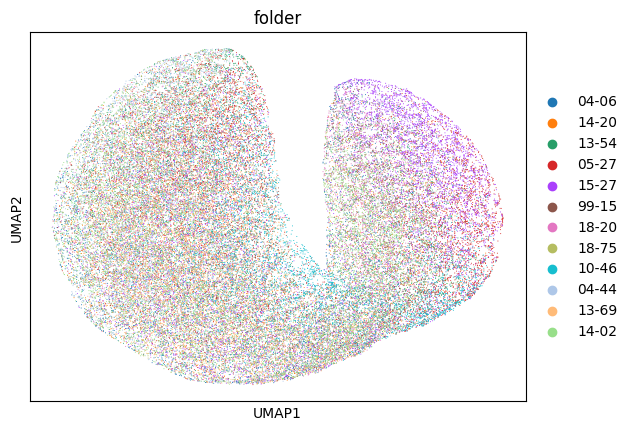

In [322]:
test_adata = adata[::10].copy()
sc.pp.neighbors(test_adata, use_rep="latent_representation")
sc.tl.umap(test_adata)
sc.pl.umap(test_adata, color="folder")

In [323]:
sc.tl.leiden(test_adata, resolution=.1, flavor="igraph", n_iterations=2)

<Axes: >

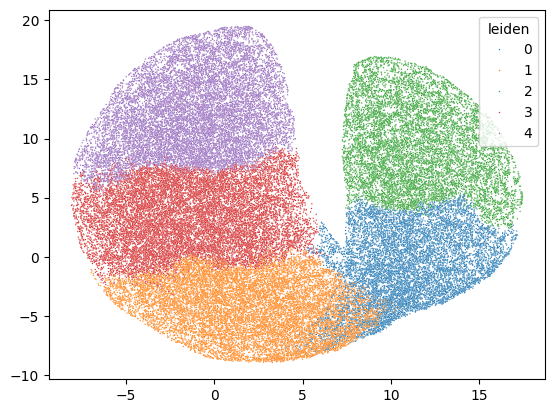

In [324]:
import seaborn as sns
sns.scatterplot(
    x=test_adata.obsm["X_umap"][:, 0],
    y=test_adata.obsm["X_umap"][:, 1],
    hue=test_adata.obs["leiden"], 
    s=1
)

<Axes: xlabel='x_centroid', ylabel='y_centroid'>

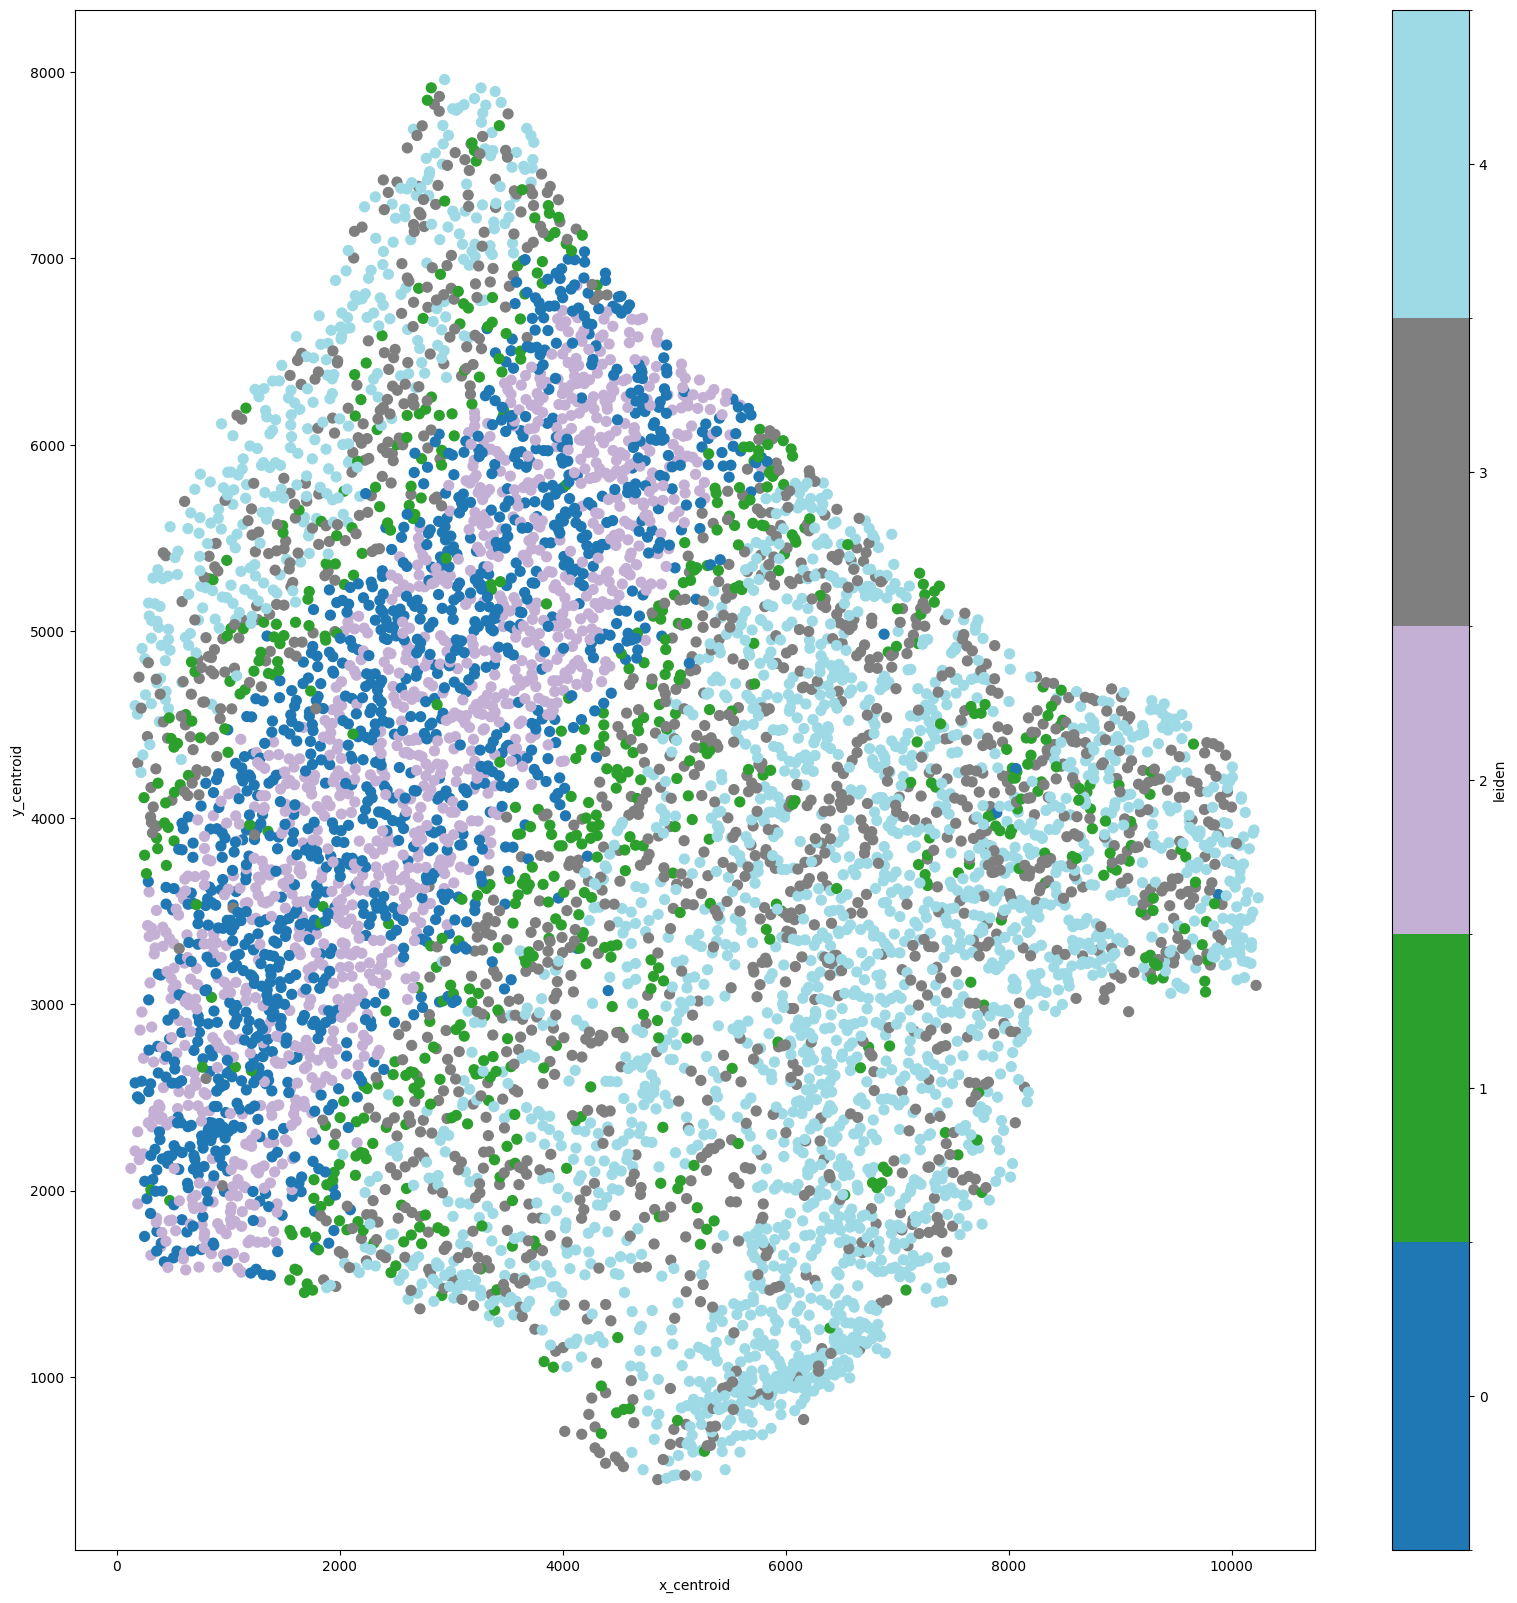

In [325]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(20, 20))
test_adata[test_adata.obs["folder"].eq("05-27")].obs.plot.scatter(
    x="x_centroid",
    y="y_centroid",
    c="leiden",
    s=50,
    cmap="tab20",
    ax=ax
)